[Open On Colab](https://colab.research.google.com/drive/1MqVwKT2KsBoTPu2WTzIfA8dLnobyrLdE?usp=sharing)

In [1]:
from google.colab import drive 
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [2]:
import pandas as pd
import tensorflow
import numpy as np
np.random.seed(1) 
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

You can download the spectrogram sets here:

1. [iOS_Mel_Spectrogramset.pkl](https://drive.google.com/file/d/1-0aKc1ZMakBHmyyRcHnnHw6VbGsctyr5/view?usp=sharing) 

2. [Android_Mel_Spectrogramset.pkl](https://drive.google.com/file/d/14Nu0kpv8mlivjgBgUQvY5yHtbyG8jTet/view?usp=sharing)

In [14]:
#importing the dataset including the created mel-spectrograms 
#working on Android users
Android_set = pd.read_pickle('/content/drive/My Drive/DATA/Android_Mel_Spectrogramset.pkl') #iOS_Mel_Spectrogramset.pkl for m4a format
Android_set

,participant,sex,age,ID_short,format,audio_type,fatigue,Spectrograms
0,PREDI_0078,1.0,43.0,Predi.Covid_0078_20200626102146,3gp,type1 & type2,False,"[[-40.12513286303115, -42.86500020727826, -42...."
1,PREDI_0078,1.0,43.0,Predi.Covid_0078_20200623090647,3gp,type1 & type2,False,"[[-35.52174398870604, -49.53425997500363, -49...."
2,PREDI_0078,1.0,43.0,Predi.Covid_0078_20200622094056,3gp,type1 & type2,False,"[[-20.745152085044417, -43.81118514925398, -43..."
3,PREDI_0078,1.0,43.0,Predi.Covid_0078_20200620071523,3gp,type1 & type2,False,"[[-26.82865797123526, -50.80539619868513, -35...."
4,PREDI_0078,1.0,43.0,Predi.Covid_0078_20200619091201,3gp,type1 & type2,False,"[[-18.285228656193382, -44.311065200834975, -4..."
...,...,...,...,...,...,...,...,...
684,PREDI_2635,1.0,29.0,Predi.Covid_2635_20210629090359,3gp,type1 & type2,False,"[[-29.5360234259978, -36.86138596075685, -35.6..."
685,PREDI_2677,1.0,35.0,Predi.Covid_2677_20210724073530,3gp,type1 & type2,False,"[[-19.049145108959845, -48.8134495289204, -48...."
686,PREDI_2677,1.0,35.0,Predi.Covid_2677_20210723065529,3gp,type1 & type2,True,"[[-20.706890052956254, -45.15509395403837, -45..."
687,PREDI_2725,0.0,34.0,Predi.Covid_2725_20210817202446,3gp,type1 & type2,True,"[[-38.18941969724684, -31.932473225833448, -33..."


In [ ]:
#Lable encoding: 1 when Fatigue = True
le = preprocessing.LabelEncoder()
Android_women['fatigue'] = le.fit_transform(Android_women['fatigue'])
y_women = Android_women['fatigue'].values

In [ ]:
#create 3 channels for the spectrograms (VGG19 has been pretrained on images having 3 channels (RGB))
spectro_women = Android_women["Spectrograms"].values
sp_women = []
for x in spectro_women:
  log_mel_spectrogram = np.stack([x, x, x], axis = -1)
  sp_women.append(log_mel_spectrogram)
X_spectro_women = np.array(sp_women, dtype=float)

In [ ]:
#call the VGG19 model
vgg19 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(196, 196, 3))

for layers in vgg19.layers:
    layers.trainable=False

print(vgg19.output)

80150528/80134624 [==============================] - 1s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [ ]:
#feature extraction
features_women = vgg19.predict(X_spectro_women)
feature_women = np.reshape(features_women,(-1,6*6*512))

In [ ]:
#Splitting data into train (80%) and test (20%) sets
X, X_test1, y_train, y_test = train_test_split(feature_women, y_women, test_size = 0.2, random_state = 1, stratify = y_women) #random_state is fixed to 1 to ensure reproducibility

##PCA reduction 

In [ ]:
pca = PCA()
pca.fit(X)
reduced = pca.transform(X)

In [ ]:
variance = pca.explained_variance_ratio_ 
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

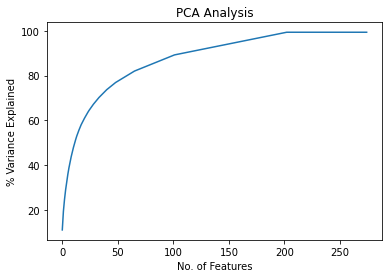

In [ ]:
plt.ylabel('% Variance Explained')
plt.xlabel('No. of Features')
plt.title('PCA Analysis')
plt.plot(var)

In [ ]:
pca = PCA(n_components=250)
pca.fit(X)
X_train = pca.transform(X)
X_test = pca.transform(X_test1)

# **Train ML models: VGG19 extracted and reduced features (Android female users)**

##Fine tune hyperparameters of ML models

In [ ]:
classifier = LogisticRegression(class_weight = 'balanced', max_iter=1000)
# Applying Grid Search to find the best parameters
parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100,1000], 'penalty': ['l1', 'l2']}]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
classifier = KNeighborsClassifier()
# Applying Grid Search to find the best parameters
parameters = [{'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
classifier = svm.SVC(kernel = 'rbf',class_weight = 'balanced', gamma='scale')
parameters = {'C': [0.1,1, 10, 100]}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
grid_search.best_params_

##Training

In [ ]:
# Model building to train
# Change the hyperparameters according to the gridsearch results
names = ['K Nearest Neighbors','Logistic regression', 'SVM rbf']
Classifiers = [
               KNeighborsClassifier(n_neighbors = 10, weights = 'distance'),
               LogisticRegression(max_iter=10000, class_weight = 'balanced', C= 0.001, penalty= 'l2'), 
               svm.SVC(kernel = 'rbf', class_weight = 'balanced', C=10)
              ]


models = zip(names, Classifiers)

from sklearn.model_selection import KFold, cross_val_score

names = []
result = []
for name, model in models:
  kfold = KFold(n_splits = 10, shuffle = True, random_state = 1)
  cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
  result.append(cv_results)
  names.append(name)
  msg = "{0}: {1} ({2})".format(name, cv_results.mean(), cv_results.std())
  print(msg)

In [ ]:
#classification report
models = zip(names, Classifiers)
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    #plot_confusion_matrix(model, X_test, y_test)
    print("--------------------------------------------------------------------------")

In [ ]:
#expected output

K Nearest Neighbors
0.7246376811594203
              precision    recall  f1-score   support

           0       0.70      0.87      0.78        38
           1       0.77      0.55      0.64        31

    accuracy                           0.72        69
   macro avg       0.74      0.71      0.71        69
weighted avg       0.73      0.72      0.72        69

--------------------------------------------------------------------------
Logistic regression
0.7681159420289855
              precision    recall  f1-score   support

           0       0.81      0.76      0.78        38
           1       0.73      0.77      0.75        31

    accuracy                           0.77        69
   macro avg       0.77      0.77      0.77        69
weighted avg       0.77      0.77      0.77        69

--------------------------------------------------------------------------
SVM rbf
0.7971014492753623
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        38
           1       0.79      0.74      0.77        31

    accuracy                           0.80        69
   macro avg       0.80      0.79      0.79        69
weighted avg       0.80      0.80      0.80        69

--------------------------------------------------------------------------

In [ ]:
#Plot the confusion matrix for each model
import matplotlib.pyplot as plt
models = zip(names, Classifiers)
for name, model in models:
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X_test)
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap = plt.cm.Blues, values_format = '.5g')
    disp.ax_.set_title(name)

    print(name)
    print(disp.confusion_matrix)
    plt.show()

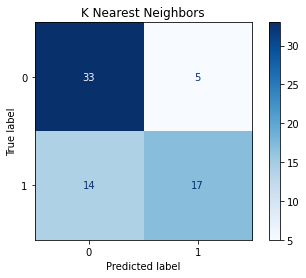

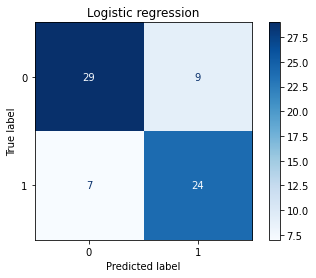

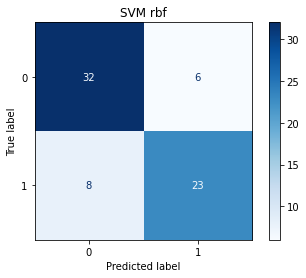

In [ ]:
#plot the aera under the curve AUC
rom sklearn import datasets, metrics, model_selection
models = zip(names, Classifiers)
for name, model in models:
    model.fit(X_train, y_train)
    metrics.plot_roc_curve(model, X_test, y_test)  
    plt.show()

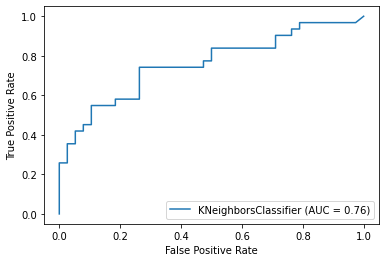

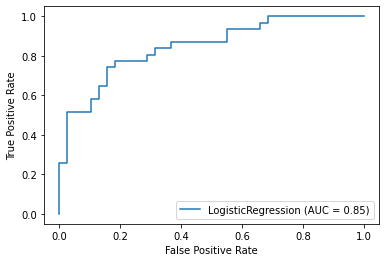

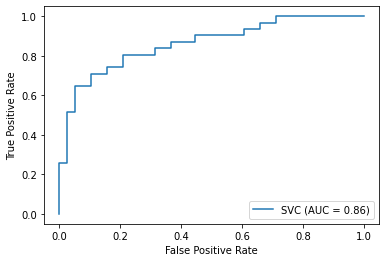

### Voting classifier 

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle =True)

estimators = []
mod1 = LogisticRegression(max_iter=10000, class_weight = 'balanced', C= 0.001, penalty= 'l2')
estimators.append(('lr', mod1))
mod2 = svm.SVC(kernel = 'rbf', class_weight = 'balanced', C=10, probability=True)
estimators.append(('RBF', mod2))
#mod3 = svm.SVC(kernel = 'sigmoid', class_weight = 'balanced', C=0.1, probability=True)
#estimators.append(('sigmoid', mod3))

ensemble = VotingClassifier(estimators, voting = 'soft', weights = [2,2])
results = cross_val_score(ensemble, X_train, y_train, cv = kfold, scoring = 'accuracy')

print(results.mean(), results.std())

0.6915343915343916 0.0590599207757892


In [ ]:
emb = ensemble.fit(X_train, y_train)
y_pred = emb.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.782608695652174
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        38
           1       0.75      0.77      0.76        31

    accuracy                           0.78        69
   macro avg       0.78      0.78      0.78        69
weighted avg       0.78      0.78      0.78        69



Voting classifier
[[30  8]
 [ 7 24]]


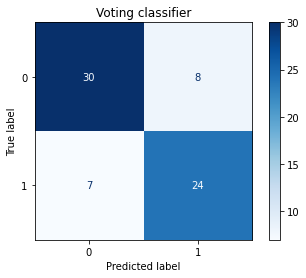

In [ ]:
import matplotlib.pyplot as plt
disp = plot_confusion_matrix(ensemble, X_test, y_test,
                                 cmap = plt.cm.Blues, values_format = '.5g')
disp.ax_.set_title('Voting classifier')

print('Voting classifier')
print(disp.confusion_matrix)
plt.show()

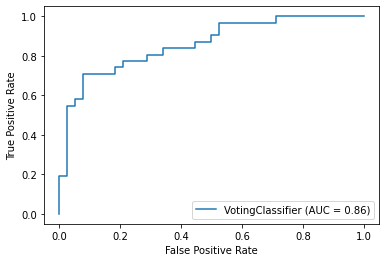

In [ ]:
from sklearn import datasets, metrics, model_selection
metrics.plot_roc_curve(ensemble, X_test, y_test)  
plt.show()

##Distribution box plot + student test for the best model selected

In [ ]:
emb = mod2.fit(X_train, y_train) #mod2 (SVM) best model
y_pred8 = emb.predict_proba(X_test)

In [ ]:
y_pred2 = y_pred8[:,1:] 

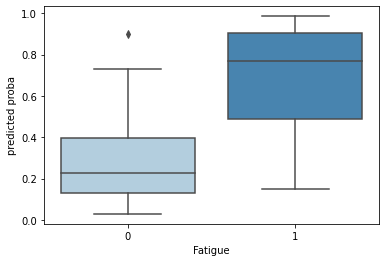

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
y_pred2 = y_pred2.reshape(69,)
sns.boxplot( x=y_test, y=y_pred2, palette="Blues").set(
    xlabel='Fatigue', 
    ylabel='predicted proba')
plt.show()

In [ ]:
list_pred = y_pred2.tolist()
list_label8 = y_test.tolist()

In [ ]:
indices_1 = [i for i, x in enumerate(list_label8) if x == 1]
indices_0 = [i for i, x in enumerate(list_label8) if x == 0]
list_pred_1=[]
for i in indices_1:
  get_val1 = list_pred[i]
  list_pred_1.append(get_val1)

In [ ]:
list_pred_0=[]
for i in indices_0:
  get_val0 = list_pred[i]
  list_pred_0.append(get_val0)

In [ ]:
from scipy.stats import ttest_ind
# compare samples
stat, p = ttest_ind(list_pred_0, list_pred_1)
print('Statistics=%.5f, p=%.5f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=-6.79991, p=0.00000
Different distributions (reject H0)


In [ ]:
p

3.449389650489302e-09

# **Train ML models: VGG19 extracted and reduced features (Android male users)**

##Fine tune hyperparameters of ML models

In [ ]:
classifier = LogisticRegression(class_weight = 'balanced', max_iter=1000)
# Applying Grid Search to find the best parameters
parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100,1000], 'penalty': ['l1', 'l2']}]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
classifier = KNeighborsClassifier()
# Applying Grid Search to find the best parameters
parameters = [{'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
classifier = svm.SVC(kernel = 'rbf',class_weight = 'balanced', gamma='scale')
parameters = {'C': [0.1,1, 10, 100]}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
grid_search.best_params_

##Training

In [ ]:
# Model building to train
# Change the hyperparameters according to the gridsearch results
names = ['K Nearest Neighbors','Logistic regression', 'SVM rbf']
Classifiers = [
               KNeighborsClassifier(n_neighbors = 10, weights = 'distance'),
               LogisticRegression(max_iter=10000, class_weight = 'balanced', C= 0.001, penalty= 'l2'), 
               svm.SVC(kernel = 'rbf', class_weight = 'balanced', C=10)
              ]


models = zip(names, Classifiers)

from sklearn.model_selection import KFold, cross_val_score

names = []
result = []
for name, model in models:
  kfold = KFold(n_splits = 10, shuffle = True, random_state = 1)
  cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
  result.append(cv_results)
  names.append(name)
  msg = "{0}: {1} ({2})".format(name, cv_results.mean(), cv_results.std())
  print(msg)

In [ ]:
#classification report
models = zip(names, Classifiers)
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    #plot_confusion_matrix(model, X_test, y_test)
    print("--------------------------------------------------------------------------")

In [ ]:
#expected output

K Nearest Neighbors
0.8260869565217391
              precision    recall  f1-score   support

           0       0.83      0.98      0.90        54
           1       0.80      0.27      0.40        15

    accuracy                           0.83        69
   macro avg       0.81      0.62      0.65        69
weighted avg       0.82      0.83      0.79        69

--------------------------------------------------------------------------
Logistic regression
0.782608695652174
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        54
           1       0.50      0.53      0.52        15

    accuracy                           0.78        69
   macro avg       0.68      0.69      0.69        69
weighted avg       0.79      0.78      0.79        69

--------------------------------------------------------------------------
SVM rbf
0.8405797101449275
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        54
           1       0.67      0.53      0.59        15

    accuracy                           0.84        69
   macro avg       0.77      0.73      0.75        69
weighted avg       0.83      0.84      0.83        69

--------------------------------------------------------------------------

In [ ]:
#Plot the confusion matrix for each model
import matplotlib.pyplot as plt
models = zip(names, Classifiers)
for name, model in models:
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X_test)
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap = plt.cm.Blues, values_format = '.5g')
    disp.ax_.set_title(name)

    print(name)
    print(disp.confusion_matrix)
    plt.show()

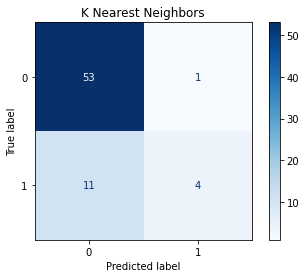

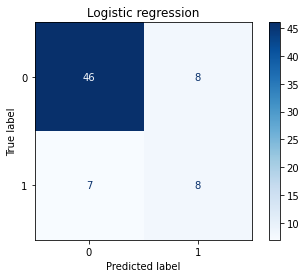

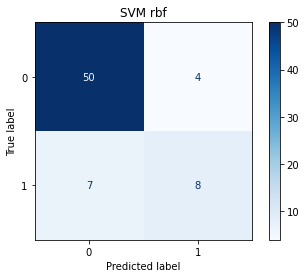

In [ ]:
#plot the aera under the curve AUC
rom sklearn import datasets, metrics, model_selection
models = zip(names, Classifiers)
for name, model in models:
    model.fit(X_train, y_train)
    metrics.plot_roc_curve(model, X_test, y_test)  
    plt.show()

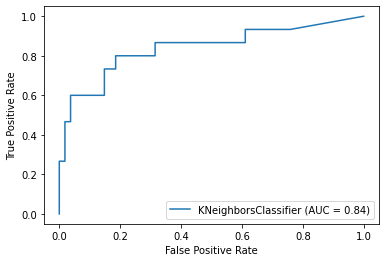

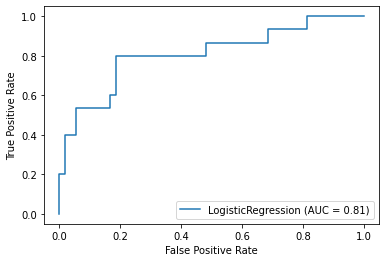

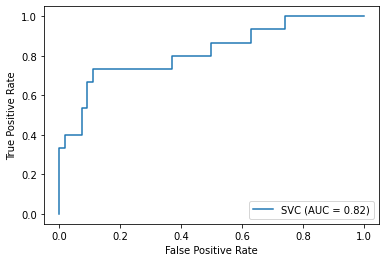

### Voting classifier 

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle =True)

estimators = []
mod1 = LogisticRegression(max_iter=10000, class_weight = 'balanced', C= 0.001, penalty= 'l2')
estimators.append(('lr', mod1))
mod2 = svm.SVC(kernel = 'rbf', class_weight = 'balanced', C=10, probability=True)
estimators.append(('RBF', mod2))
#mod3 = svm.SVC(kernel = 'sigmoid', class_weight = 'balanced', C=1, probability=True)
#estimators.append(('sigmoid', mod3))

ensemble = VotingClassifier(estimators, voting = 'soft', weights = [1,2])
results = cross_val_score(ensemble, X_train, y_train, cv = kfold, scoring = 'accuracy')

print(results.mean(), results.std())

0.8585978835978837 0.06946006375115282


In [ ]:
emb = ensemble.fit(X_train, y_train)
y_pred = emb.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8405797101449275
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        54
           1       0.64      0.60      0.62        15

    accuracy                           0.84        69
   macro avg       0.77      0.75      0.76        69
weighted avg       0.84      0.84      0.84        69



Voting classifier
[[49  5]
 [ 6  9]]


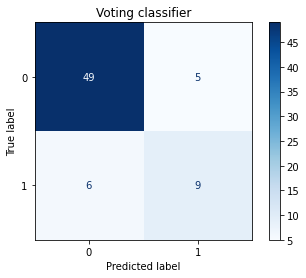

In [ ]:
import matplotlib.pyplot as plt
disp = plot_confusion_matrix(ensemble, X_test, y_test,
                                 cmap = plt.cm.Blues, values_format = '.5g')
disp.ax_.set_title('Voting classifier')

print('Voting classifier')
print(disp.confusion_matrix)
plt.show()

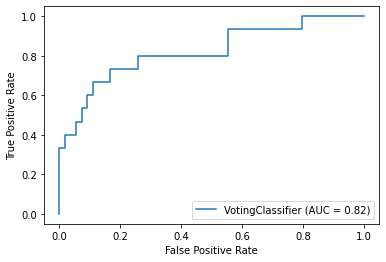

In [ ]:
from sklearn import datasets, metrics, model_selection
metrics.plot_roc_curve(ensemble, X_test, y_test)  
plt.show()

##Distribution box plot + student test

In [ ]:
emb = ensemble.fit(X_train, y_train)
y_pred8 = emb.predict_proba(X_test)

In [ ]:
y_pred2 = y_pred8[:,1:] 

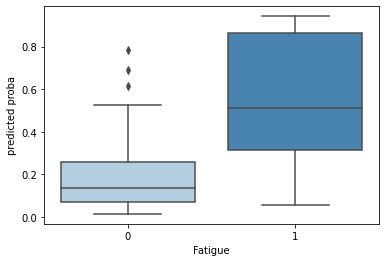

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
y_pred2 = y_pred2.reshape(69,)
sns.boxplot( x=y_test, y=y_pred2, palette="Blues").set(
    xlabel='Fatigue', 
    ylabel='predicted proba')
plt.show()

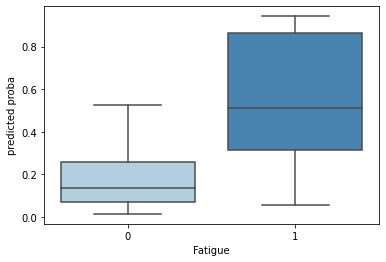

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
y_pred2 = y_pred2.reshape(69,)
sns.boxplot( x=y_test, y=y_pred2, palette="Blues", showfliers=False).set(
    xlabel='Fatigue', 
    ylabel='predicted proba')
plt.show()

In [ ]:
from scipy.stats import ttest_ind
# compare samples
stat, p = ttest_ind(y_test, y_pred2)
print('Statistics=%.5f, p=%.5f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=-0.86116, p=0.39066
Same distributions (fail to reject H0)


In [ ]:
list_pred = y_pred2.tolist()
list_label8 = y_test.tolist()

In [ ]:
indices_1 = [i for i, x in enumerate(list_label8) if x == 1]
indices_0 = [i for i, x in enumerate(list_label8) if x == 0]
list_pred_1=[]
for i in indices_1:
  get_val1 = list_pred[i]
  list_pred_1.append(get_val1)

In [ ]:
list_pred_0=[]
for i in indices_0:
  get_val0 = list_pred[i]
  list_pred_0.append(get_val0)

In [ ]:
from scipy.stats import ttest_ind
# compare samples
stat, p = ttest_ind(list_pred_0, list_pred_1)
print('Statistics=%.5f, p=%.5f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=-5.50097, p=0.00000
Different distributions (reject H0)


In [ ]:
p

6.388920047833723e-07

In [ ]:
from sklearn.metrics import brier_score_loss
brier_score_loss(y_test, y_prob)

0.1210408801648304